In [2]:
packages <- c("survRM2", "mvtnorm", "ggplot2", "MASS", "tidyr", "survival", "nph",
              "foreach", "doParallel", "cowplot", "IRdisplay", "rlang")

install_and_load <- function(package) {
  if (!require(package, character.only = TRUE)) {
    install.packages(package)
    library(package, character.only = TRUE)
  }
}

invisible(lapply(packages, install_and_load))

n_cores <- detectCores()
cluster <- makeCluster(16) # How many cores we use
registerDoParallel(cluster)
# multi thread
invisible(clusterEvalQ(cluster, #import packages to parallel 
  {
  library('survRM2')
  library('mvtnorm')
  library('cubature')
  library('survival')
  library('nph')
  library("simtrial")
  library("foreach")
  }))

source('Rfiles/Function.R')
clusterExport(cluster, "expo_gen_2stages")

# RMST Estimation with censoring in interim 1 year

RMST of Control arm is: 0.495229 
Variance of RMST estimation of Control arm is: 2.732952e-05 
RMST of Experiment arm is: 0.6448322 
Variance of RMST estimation of Experiment arm is: 2.831875e-05

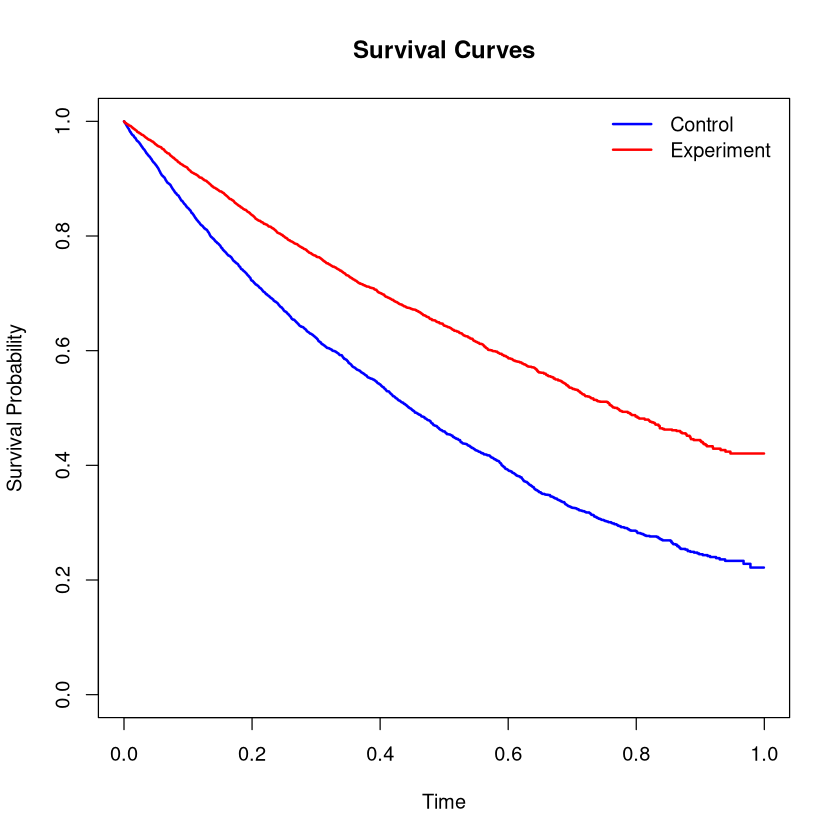

In [36]:
set.seed(2024)
data_C <- expo_gen_2stages(N = 10000, acc_time = acc_time, lambda = lambda_H0, 
                           dist = 'exp', cen_time = cen_time, arm = 0, interim = 1)[ , c(2,3,1)]
data_E <- expo_gen_2stages(N = 10000 ,acc_time = acc_time, lambda = lambda_H1, 
                           dist = 'exp', cen_time = cen_time, arm = 1, interim = 1)[ , c(2,3,1)]
pre_data <- rbind(data_C,data_E)
rmst_result_int <- rmst2(pre_data[,1], pre_data[,2], pre_data[,3],tau = 0.96)

cat('RMST of Control arm is:',rmst_result_int$RMST.arm0$rmst[1],'\n')
cat('Variance of RMST estimation of Control arm is:',rmst_result_int$RMST.arm0$rmst.var,'\n')
cat('RMST of Experiment arm is:',rmst_result_int$RMST.arm1$rmst[1],'\n')
cat('Variance of RMST estimation of Experiment arm is:',rmst_result_int$RMST.arm1$rmst.var)
fit <- survfit(Surv(pre_data[,1], pre_data[,2]) ~ pre_data[,3])
plot(fit, col = c("blue", "red"), lwd = 2, xlab = "Time", ylab = "Survival Probability", main = "Survival Curves")
legend("topright", legend = c("Control", "Experiment"), col = c("blue", "red"), lwd = 2, bty = "n")

### RMST Estimation with censoring in the whole study

RMST of Control arm is: 0.4923799 
Variance of RMST estimation of Control arm is: 1.212278e-05 
RMST of Experiment arm is: 0.6585054 
Variance of RMST estimation of Experiment arm is: 1.264252e-05

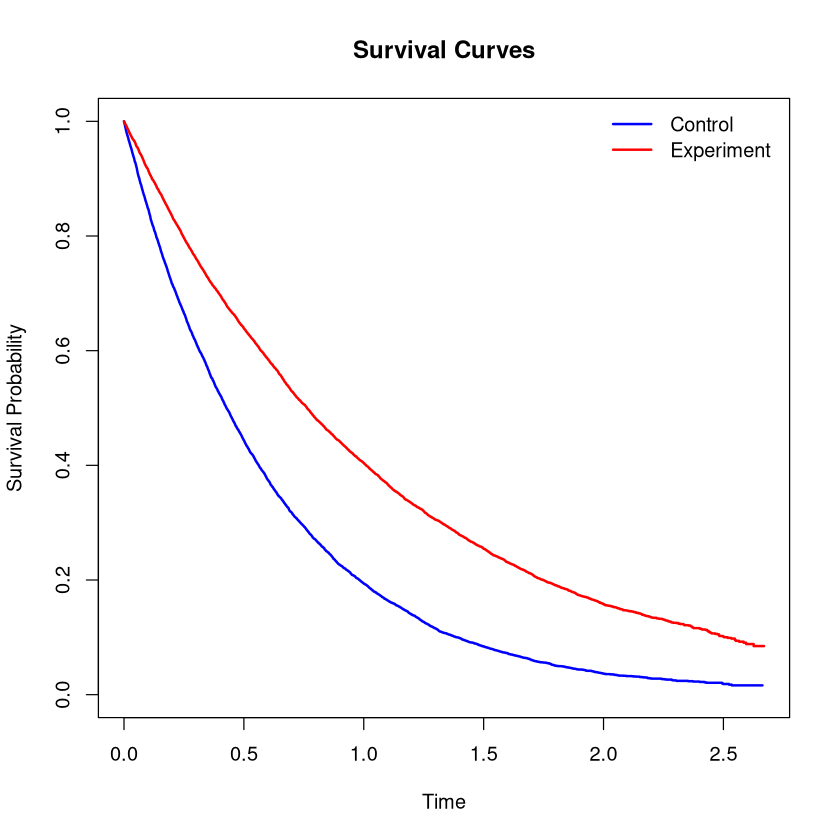

In [37]:
set.seed(2024)
data_C <- expo_gen_2stages(N = 10000, acc_time = acc_time, lambda = lambda_H0, 
                           dist = 'exp', cen_time = cen_time, arm = 0, interim = 1)[ , c(4,5,1)]
data_E <- expo_gen_2stages(N = 10000 ,acc_time = acc_time, lambda = lambda_H1, 
                           dist = 'exp', cen_time = cen_time, arm = 1, interim = 1)[ , c(4,5,1)]
pre_data <- rbind(data_C,data_E)
rmst_result_all <- rmst2(pre_data[,1], pre_data[,2], pre_data[,3],tau = 1)

cat('RMST of Control arm is:',rmst_result_all$RMST.arm0$rmst[1],'\n')
cat('Variance of RMST estimation of Control arm is:',rmst_result_all$RMST.arm0$rmst.var,'\n')
cat('RMST of Experiment arm is:',rmst_result_all$RMST.arm1$rmst[1],'\n')
cat('Variance of RMST estimation of Experiment arm is:',rmst_result_all$RMST.arm1$rmst.var)
fit <- survfit(Surv(pre_data[,1], pre_data[,2]) ~ pre_data[,3])
plot(fit, col = c("blue", "red"), lwd = 2, xlab = "Time", ylab = "Survival Probability", main = "Survival Curves")
legend("topright", legend = c("Control", "Experiment"), col = c("blue", "red"), lwd = 2, bty = "n")

------

# 2 stages Experiment

#### Setting: acc_time = 1.67, cen_time = 1, interim $\tau_1 = 1$
####  $\textcolor{lightgreen}{H_0 : \lambda_0 = \lambda_1 = 1.609}$    
####  $\textcolor{lightgreen}{H_1 : \lambda_0 = 1.609,\ \lambda_1 = 0.916}$  
#### α = 0.1, power = 0.9. Sample size = 102 (51 per arm)   
#### censoring dist in interim: $\tilde{C_i} \sim U[0,\tau_1]$.  After interim: $C_i \sim U[b=1,a+b=2.67]$


In [ ]:
sim_size <- 10000 
acc_time <- 1.67
cen_time <- 1
lambda_H0 <- 1.609
lambda_H1 <- 0.916
interim <- 1
set.seed(2024)
n <- 51 

data_C <- expo_gen_2stages(N = n * sim_size, acc_time = acc_time, lambda = lambda_H0, dist = 'exp', 
                           cen_time = cen_time,arm = 0, interim = interim)    
data_E_H0 <- expo_gen_2stages(N = n * sim_size, acc_time = acc_time, lambda = lambda_H0, dist = 'exp', 
                                cen_time = cen_time,arm = 1, interim = interim)
data_E_H1 <- expo_gen_2stages(N = n * sim_size, acc_time = acc_time, lambda = lambda_H1, dist = 'exp', 
                                cen_time = cen_time,arm = 1, interim = interim)                             

data_C_int <- data_C[ , c(2,3,1)]  # In the order of (obs_time, event, arm) for RMST test
data_E_H0_int <- data_E_H0[ , c(2,3,1)]
data_E_H1_int <- data_E_H1[ , c(2,3,1)]
rmst_h0_int <- RMST_sim_cal(n = n,data_E = data_E_H0_int, data_C = data_C_int,tau = interim,sim_size = sim_size)
rmst_h1_int <- RMST_sim_cal(n = n,data_E = data_E_H1_int, data_C = data_C_int,tau = interim,sim_size = sim_size)

data_C_fin <- data_C[ , c(4,5,1)]
data_E_H0_fin <- data_E_H0[ , c(4,5,1)]
data_E_H1_fin <- data_E_H1[ , c(4,5,1)]
rmst_h0_fin <- RMST_sim_cal(n = n,data_E = data_E_H0_fin, data_C = data_C_fin,tau = 2,sim_size = sim_size)
rmst_h1_fin <- RMST_sim_cal(n = n,data_E = data_E_H1_fin, data_C = data_C_fin,tau = 2,sim_size = sim_size)
rmst_data <- rbind(rmst_h0_int, rmst_h1_int, rmst_h0_fin, rmst_h1_fin)

-----

## Log rank test for 2 stages to find the best critical value
### <span style="color:yellow"> find_m_logrank is similar to find_m_t_RMST. 
### <span style="color:yellow"> I am trying to reproduce the result in Jung(2017) by grid searching 

#### During the interim, process to stage II when:
#### $\textcolor{lightgreen}{\frac{W_1}{\sigma_1}>m_1}$, where $W_1\ ,\ \sigma_1$ are log rank test statistics and its variance in interim period
#### Reject H1 final stage when:
#### $\textcolor{lightgreen}{\frac{W_1}{\sigma_1}>m_1\ \& \ \frac{W}{\sigma}>m_2}$

### Conduct a log rank test at the end of the 2 stages trial. Interim $\tau = 1$ year  
### <span style="color:yellow">The power is almost the same as 2 stages log rank design


In [ ]:
# Empirical alpha
log_rank_sim(data_C = data_C_fin, data_E = data_E_H0_fin, sim_size =  sim_size,
                            n = n, alpha = 0.1, sided = 'greater')$rejection
# Empirical power
log_rank_sim(data_C = data_C_fin, data_E = data_E_H1_fin, sim_size =  sim_size,
                            n = n, alpha = 0.1, sided = 'greater')$rejection                          

[1] 0.0999

[1] 0.9098

### Some experiments in Jung 2017 p650 table 1. Stop for futility only.
#### Optimal: $\lambda_2=0.9,\lambda_1 = \lambda_2*\Delta,n = 187, n_1 = 95, \alpha = 0.05, 1-\beta = 0.8$
#### $PET_0 = 0.556, PET_1 = 0.104$
#### Use my searching loop to find the critical value $m1, m2$

In [16]:
sim_size <- 10000 
acc_time <- 174 / 60
cen_time <- 1
lambda_H0 <- 0.9 * 1.5
lambda_H1 <- 0.9
interim <- 112 / 60
set.seed(2024)
n <- ceiling(174/2)  #sample size per arm 

data_C <- expo_gen_2stages(N = n * sim_size, acc_time = acc_time, lambda = lambda_H0, dist = 'exp', 
                            cen_time = cen_time,arm = 0, interim = interim)    
data_E_H0 <- expo_gen_2stages(N = n * sim_size, acc_time = acc_time, lambda = lambda_H0, dist = 'exp', 
                                 cen_time = cen_time,arm = 1, interim = interim)
data_E_H1 <- expo_gen_2stages(N = n * sim_size, acc_time = acc_time, lambda = lambda_H1, dist = 'exp', 
                                 cen_time = cen_time,arm = 1, interim = interim)                             

z_stats_h0_int <- log_rank_sim(data_C = data_C[ , c(2,3,1)], data_E = data_E_H0[ , c(2,3,1)],
                              sim_size =  sim_size, n = n, alpha = 0.05, sided = 'greater')$z_stats
z_stats_h1_int <- log_rank_sim(data_C = data_C[ , c(2,3,1)], data_E = data_E_H1[ , c(2,3,1)], 
                              sim_size =  sim_size, n = n, alpha = 0.05, sided = 'greater')$z_stats
z_stats_h0_fin <- log_rank_sim(data_C =  data_C[ , c(4,5,1)], data_E = data_E_H0[ , c(4,5,1)], 
                              sim_size =  sim_size, n = n, alpha = 0.05, sided = 'greater')$z_stats
z_stats_h1_fin <- log_rank_sim(data_C =  data_C[ , c(4,5,1)], data_E = data_E_H1[ , c(4,5,1)], 
                              sim_size =  sim_size, n = n, alpha = 0.05, sided = 'greater')$z_stats
logrank_data <- rbind(z_stats_h0_int, z_stats_h1_int, z_stats_h0_fin, z_stats_h1_fin)

find_m_logrank(logrank_data = logrank_data, search_times = 1000, alpha = 0.05, sim_size = sim_size)


m1,m2,PET0,PET1,alpha,power
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
-0.308172,1.642335,0.3844,0.0288,0.0499,0.7981


### Use the cut off point in Jung's paper
### <span style="color:yellow"> Same as the shown result in Jung's paper (yellow mark in the graph below)

In [ ]:
m1 <- -0.32
m2 <- 1.641
#PET0
1 - sum(z_stats_h0_int > m1)/sim_size
#PET1
1 - sum(z_stats_h1_int > m1)/sim_size
#alpha
sum((logrank_data[1, ] > m1) & (logrank_data[3, ]  > m2))/sim_size
#power 
sum((logrank_data[2, ] > m1) & (logrank_data[4, ]  > m2))/sim_size

[1] 0.3803

[1] 0.0277

[1] 0.0501

[1] 0.7988

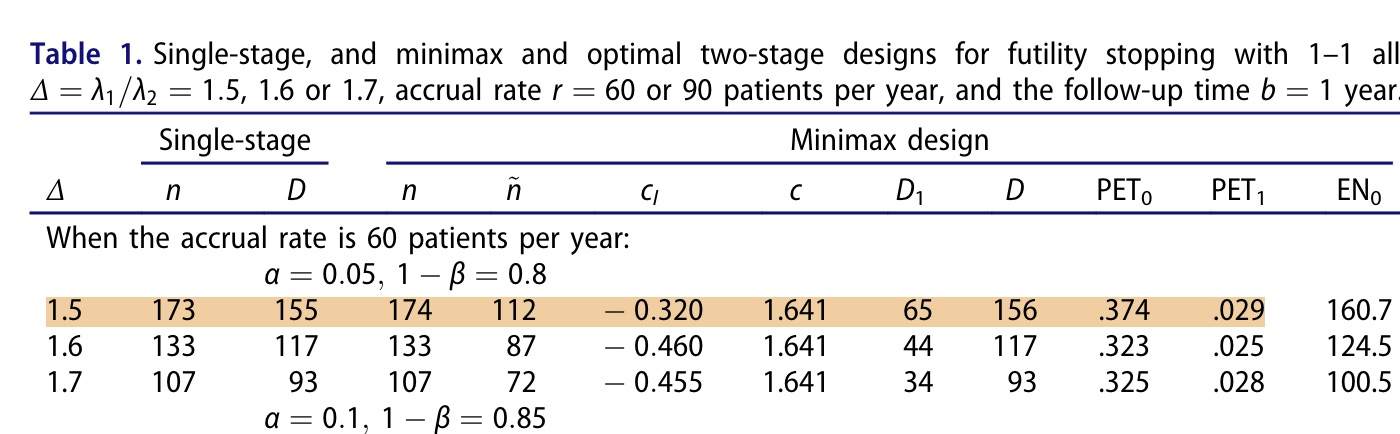

In [ ]:
display_jpeg(file='figures/Jung(2017)_table_1.jpeg')

#### Under PH, we can find a proper critical value to make 2 stages power ~ single stage 
#### This conclusion is true when stopping for both superiority and futility or for futility only.
#### overall $\textcolor{lightgreen}{\alpha = P(\frac{W_1}{\sigma_1}>C_u|H_0) + P(C_l<\frac{W_1}{\sigma_1}<C_u,\frac{W}{\sigma}>C|H_0)}$
-------

# Our Rejection Region
### <span style="color:yellow">E and C are the RMST value of experiment group and control group respectively
### subscript 1 means interim period, 2 for final period
#### Stage I : process to stage II (reject $H_0$) when:  
####  $\textcolor{lightgreen}{E(\tau_1) - C(\tau_1) > m_1\ \&\  E(\tau_1) > t_1}$, where $m_1>0$
### Stage II:
#### reject $H_0$ when:  
#### $ \textcolor{lightgreen}{E(\tau_1)-C(\tau_1)>m_1\ \&\  E(\tau_1)>t_1\ \&\  E(\tau_2)-C(\tau_2)>m_2\ \&\  E(\tau_2)>t_2},\ $  $m_1, m_2 >0$


### By the asymptotic normality of RMST:
$$
 \textcolor{lightgreen}{[E1-C1,\ E1,\ E2-C2,\ E2] \sim \mathcal{N}\ (\ \hat{\mu},\ \hat{\Sigma}\ )}
$$

$$
\hat{\Sigma} = 
 \left[
 \begin{matrix}
   Var(E1)+Var(C1) & Var(E1) & Cov(E1,E2)+Cov(C1,C2) & Cov(E1,E2) \\
                   & Var(E1) & Cov(E1,E2) & Cov(E1,E2) \\
                   &         & Var(E2)+Var(C2) & Var(E2)\\
                   &         &                 & Var(E2)\\
  \end{matrix}
\right]
$$

## Monte Carlo
$ var[\widehat{RMST_{E1}}]=\frac{1}{B}\sum\limits_{i = 1}^{B} (\widehat{RMST_{E1,i}} - \bar{RMST_{E1}})^2$

Similar to Lu(2021) 

$$
 \left[
 \begin{matrix}
   Var(\hat{E1}) & Cov(\hat{E1}, \hat{E2}) \\
   Cov(\hat{E1}, \hat{E2}) & Var{\hat{E2}} \\
  \end{matrix}
  \right] = 

\frac{1}{B}\sum\limits_{i = 1}^{B} 
 \left[
 \begin{matrix}
   \widehat{RMST_{E1}} - \bar{RMST_{E1}} \\
   \widehat{RMST_{E2}} - \bar{RMST_{E2}} \\
  \end{matrix}
  \right] ^{\bigotimes2}_i 
$$

$ \bar{RMST_{E1}} = \frac{1}{B}\sum^{B}_{i = 1}RMST_{E1,i}$ is the mean RMST value of simulation
#### <span style="color:yellow">Use the setting of Jung 2017 table 1 first row (Minimax)




In [4]:
set.seed(2024)
sim_size <- 10000 
r <- 60
acc_time <- 174 / r
cen_time <- 1
lambda_H0 <- 0.9 * 1.5
lambda_H1 <- 0.9
interim <- 112 / r
n <- ceiling(174 / 2)

data_C <- expo_gen_2stages(N = n * sim_size, acc_time = acc_time, lambda = lambda_H0, dist = 'exp', 
                           cen_time = cen_time,arm = 0, interim = interim)    
data_E_H0 <- expo_gen_2stages(N = n * sim_size, acc_time = acc_time, lambda = lambda_H0, dist = 'exp', 
                                cen_time = cen_time,arm = 1, interim = interim)
data_E_H1 <- expo_gen_2stages(N = n * sim_size, acc_time = acc_time, lambda = lambda_H1, dist = 'exp', 
                                cen_time = cen_time,arm = 1, interim = interim) 

rmst_h0_int <- RMST_sim_cal(n = n, data_E = data_E_H0[ , c(2,3,1)], data_C = data_C[ , c(2,3,1)],
                            tau = interim,sim_size = sim_size)
rmst_h0_fin <- RMST_sim_cal(n = n, data_E = data_E_H0[ , c(4,5,1)], data_C = data_C[ , c(4,5,1)],
                            tau = acc_time + cen_time,sim_size = sim_size)                                 
rmst_h1_int <- RMST_sim_cal(n = n, data_E = data_E_H1[ , c(2,3,1)], data_C = data_C[ , c(2,3,1)],
                            tau = interim,sim_size = sim_size)
rmst_h1_fin <- RMST_sim_cal(n = n, data_E = data_E_H1[ , c(4,5,1)], data_C = data_C[ , c(4,5,1)],
                            tau = acc_time + cen_time,sim_size = sim_size)
rmst_data <- rbind(rmst_h0_int, rmst_h1_int, rmst_h0_fin, rmst_h1_fin)

# Under H0
mu_cov_h0 <- mu_cov_mc(rmst_int = rmst_h0_int, rmst_fin = rmst_h0_fin, sim_size = sim_size)
# Under H1
mu_cov_h1 <- mu_cov_mc(rmst_int = rmst_h1_int, rmst_fin = rmst_h1_fin, sim_size = sim_size)

z_stats_h0_int <- log_rank_sim(data_C = data_C[ , c(2,3,1)], data_E = data_E_H0[ , c(2,3,1)],
                              sim_size =  sim_size, n = n, alpha = 0.05, sided = 'greater')$z_stats
z_stats_h1_int <- log_rank_sim(data_C = data_C[ , c(2,3,1)], data_E = data_E_H1[ , c(2,3,1)], 
                              sim_size =  sim_size, n = n, alpha = 0.05, sided = 'greater')$z_stats
z_stats_h0_fin <- log_rank_sim(data_C =  data_C[ , c(4,5,1)], data_E = data_E_H0[ , c(4,5,1)], 
                              sim_size =  sim_size, n = n, alpha = 0.05, sided = 'greater')$z_stats
z_stats_h1_fin <- log_rank_sim(data_C =  data_C[ , c(4,5,1)], data_E = data_E_H1[ , c(4,5,1)], 
                              sim_size =  sim_size, n = n, alpha = 0.05, sided = 'greater')$z_stats
logrank_data <- rbind(z_stats_h0_int, z_stats_h1_int, z_stats_h0_fin, z_stats_h1_fin)

cat('----------------- Under H0 -----------------')
mu_cov_h0$mu
mu_cov_h0$sigma
cat('----------------- Under H1 -----------------')
mu_cov_h1$mu
mu_cov_h1$sigma

----------------- Under H0 -----------------

[1] -0.0009244598  0.6437030906 -0.0008266902  0.7209832338

0.013347573,0.006682451,0.007468517,0.003756487
0.006682451,0.006682451,0.003756487,0.003756487
0.007468517,0.003756487,0.011432684,0.005749263
0.003756487,0.003756487,0.005749263,0.005749263


----------------- Under H1 -----------------

[1] 0.1872043 0.8355180 0.3104179 1.0345292

0.016176574,0.009440102,0.009336402,0.005552532
0.009440102,0.009440102,0.005552532,0.005552532
0.009336402,0.005552532,0.017116352,0.011343458
0.005552532,0.005552532,0.011343458,0.011343458


#### The mean and cov estimation shown above are packed in function 'mu_cov_mc'
#### The Estimation of $\mu\ and\ \Sigma | H_0,\ H_1$ are shown above 

------

# <span style="color:yellow">  Parameter Optimization (Grid Search)
Reference: Zhou(2017) BOP2 Bayesian design. DOI:10.1002/sim.7338

#### In order to solve the critical values ($m_1,\ t_1,\ m_2,\ t_2$), a function that can control the normal probability is required. The following $\mathcal{f}(n)$  is what we proposed.
$$
\Large \mathcal{f}(n) = \mathcal{e}^{-\ \gamma · \frac{n}{N}}
$$
#### $n$ is the sample size(2 arms) of interim period. $N$ is the final total sample size of 2 arms. 
#### Then we set the following constraints:
$$
\begin{aligned}
\large P(E_1 - C_1 > m_1) &= \mathcal{f}(n)  \\
\large P(E_1 - C_1 > m_1\ \&\ E_1 > t_1) &= \lambda · \mathcal{f}(n) \\
\large P(E_2 - C_2 > m_2) &=  \mathcal{f}(N) \\
\large P(E_2 - C_2 > m_2\ \&\ E_2 > t_2) &= \lambda · \mathcal{f}(N) \\
0<\lambda<1,\ \gamma>0
\end{aligned}
$$

#### $ \mathcal{f}(n)$ is a monotonously decereasing funciton of n, which means that two probability constraints in interim period will go up when the interim sample size n decrease. <span style="color:yellow"> It leads to a small early stop probability with an insufficient interim sample size.  
#### Then we grid search $(\lambda, \gamma)$ . Each pair of $(\lambda, \gamma)$ determines a set of ($m_1,\ t_1,\ m_2,\ t_2$) by normal calculation. Record critical values sets that yield the desirable overall type I error $\alpha$:
$$
\large P(E_1-C_1>m_1\ \&\  E_1>t_1\ \&\  E_2 - C_2>m_2\ \&\  E_2>t_2\ |H_0) < \alpha
$$
#### Find the most powerful one under $H_1$ among these ($m_1,\ t_1,\ m_2,\ t_2$)
#### * The grid searching procedure above is packed in function: 'adp_grid_src'

In [5]:
best_our <- adp_grid_src(rmst_data = rmst_data, mu_cov_h0 = mu_cov_h0, mu_cov_h1 = mu_cov_h1, 
                int_n = interim * r, fin_n = 2 * n, alpha = 0.05, sim_size = sim_size)
best_our

m1,t1,m2,t2,lambda,gamma,PET0,PET1,alpha,power
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
0.003513595,0.6497229,0.1520734,0.8507677,0.99,0.12,0.6613,0.0731,0.0228,0.8468


### Use the normality of 4d RMST to calculate the Type I error and Power
### * The alpha and power calculated in the function above is based on the simulated survival data

In [6]:
threshold <- as.numeric(best_our[1:4])
# Monte Carlo normal probability 
norm_sam_h0 <- mvrnorm(100000, mu = mu_cov_h0$mu, Sigma = mu_cov_h0$sigma)
norm_sam_h1 <- mvrnorm(100000, mu = mu_cov_h1$mu, Sigma = mu_cov_h1$sigma)

cat('The type one error is:',sum(apply(norm_sam_h0, 1, function(x) all(x > threshold))) / 100000, '\n')
cat('The Power is:',sum(apply(norm_sam_h1, 1, function(x) all(x > threshold))) / 100000, '\n')

The type one error is: 0.02071 
The Power is: 0.83078 


### <span style="color:yellow">  The power is slightly higher than LR but cost should be global robustness (Litwin 2017)  
------


## Global Robustness
#### Litwin mentioned that when the real distribution parameters vary from the stated ones, the alpha under the same critical values will increase sharply. This method will sacrify globally robustness.
### <span style="color:yellow"> Compare the robustness between LR test and Our method when Hazard Ratio change
#### $\lambda_E| H_1 = 0.9,\ \lambda_C/\lambda_E = 1.5$ Follow Jung 2017 table1

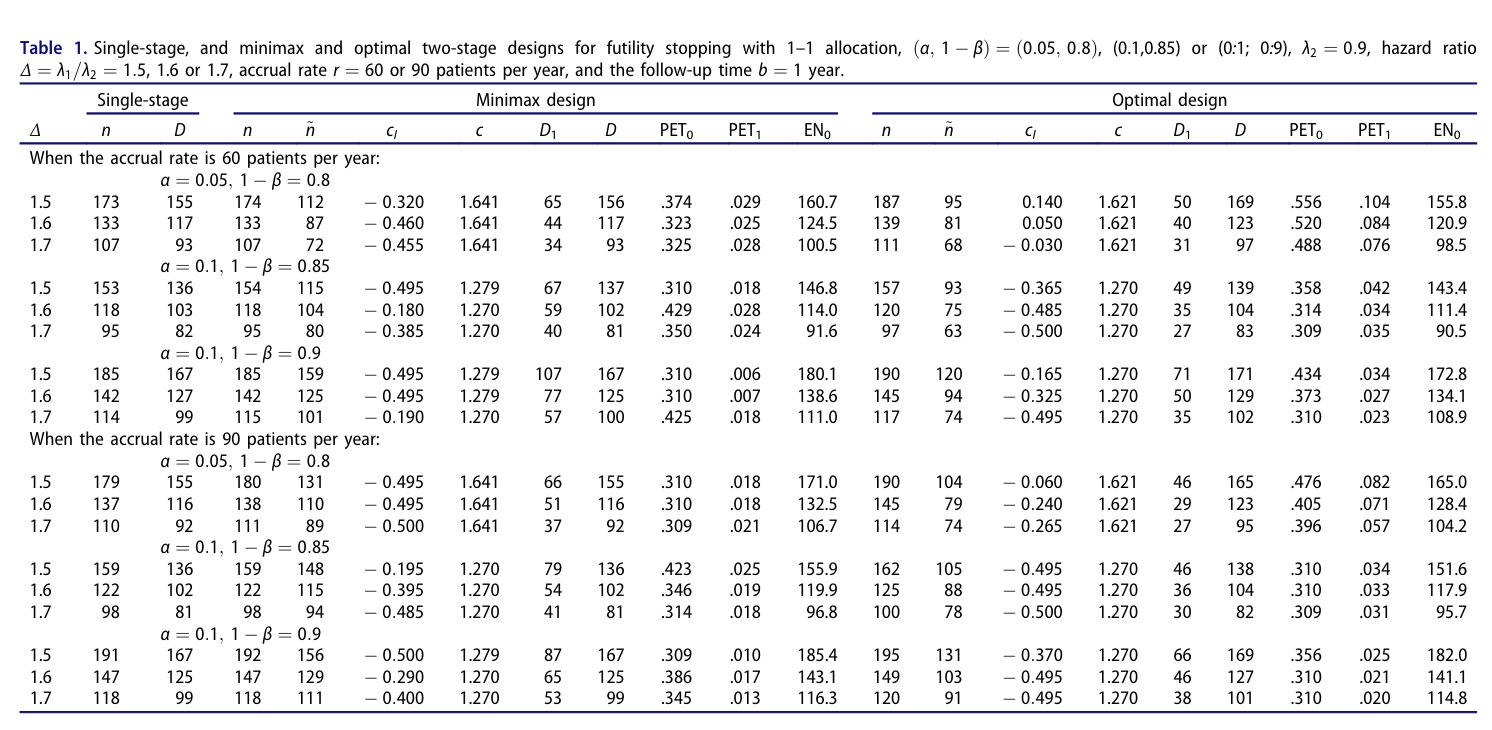

In [8]:
best_lr <- find_m_logrank(logrank_data = logrank_data, search_times = 1000, alpha = 0.05, sim_size = sim_size)
best_rmst <- find_m_t_RMST(rmst_data = rmst_data, search_times = 1000,  alpha = 0.05, sim_size = sim_size)
display_jpeg(file='figures/Jung2017_full_table1.jpeg')

### Change $\lambda_C/\lambda_E$ under <span style="color:yellow"> the same critical value(cutoff) 

In [10]:
m1 <- as.numeric(best_our[1])
t1 <- as.numeric(best_our[2])
m2 <- as.numeric(best_our[3])
t2 <- as.numeric(best_our[4])

# Critical value of LR and simple RMST
m1_lr <- best_lr$m1
m2_lr <- best_lr$m2
m1_rmst <- best_rmst$m1
m2_rmst <- best_rmst$m2

diff_HR <- foreach(HR = seq(1.3, 1.7, by = 0.05), .combine = rbind) %dopar%
{
    lambda_H0 <- 0.9 * HR
    data_C <- expo_gen_2stages(N = n * sim_size, acc_time = acc_time, lambda = lambda_H0, dist = 'exp', 
                           cen_time = cen_time,arm = 0, interim = interim)    
    data_E_H0 <- expo_gen_2stages(N = n * sim_size, acc_time = acc_time, lambda = lambda_H0, dist = 'exp', 
                                cen_time = cen_time,arm = 1, interim = interim)
    data_E_H1 <- expo_gen_2stages(N = n * sim_size, acc_time = acc_time, lambda = lambda_H1, dist = 'exp', 
                                cen_time = cen_time,arm = 1, interim = interim) 

    rmst_h0_int <- RMST_sim_cal(n = n, data_E = data_E_H0[ , c(2,3,1)], data_C = data_C[ , c(2,3,1)],
                            tau = interim,sim_size = sim_size)
    rmst_h0_fin <- RMST_sim_cal(n = n, data_E = data_E_H0[ , c(4,5,1)], data_C = data_C[ , c(4,5,1)],
                            tau = acc_time + cen_time, sim_size = sim_size)                        
    rmst_h1_int <- RMST_sim_cal(n = n, data_E = data_E_H1[ , c(2,3,1)], data_C = data_C[ , c(2,3,1)],
                            tau = interim,sim_size = sim_size)
    rmst_h1_fin <- RMST_sim_cal(n = n, data_E = data_E_H1[ , c(4,5,1)], data_C = data_C[ , c(4,5,1)],
                            tau = acc_time + cen_time, sim_size = sim_size)

    z_stats_h0_int <- log_rank_sim(data_C = data_C[ , c(2,3,1)], data_E = data_E_H0[ , c(2,3,1)],
                              sim_size =  sim_size, n = n, alpha = 0.05, sided = 'greater')$z_stats
    z_stats_h1_int <- log_rank_sim(data_C = data_C[ , c(2,3,1)], data_E = data_E_H1[ , c(2,3,1)], 
                              sim_size =  sim_size, n = n, alpha = 0.05, sided = 'greater')$z_stats
    z_stats_h0_fin <- log_rank_sim(data_C =  data_C[ , c(4,5,1)], data_E = data_E_H0[ , c(4,5,1)], 
                              sim_size =  sim_size, n = n, alpha = 0.05, sided = 'greater')$z_stats
    z_stats_h1_fin <- log_rank_sim(data_C =  data_C[ , c(4,5,1)], data_E = data_E_H1[ , c(4,5,1)], 
                              sim_size =  sim_size, n = n, alpha = 0.05, sided = 'greater')$z_stats

    a_lr <- sum(z_stats_h0_int > m1_lr & z_stats_h0_fin > m2_lr) / sim_size
    power_lr <- sum(z_stats_h1_int > m1_lr & z_stats_h1_fin > m2_lr) / sim_size
    pet0_lr <- sum(z_stats_h0_int <= m1_lr) / sim_size
    pet1_lr <- sum(z_stats_h1_int <= m1_lr) / sim_size

    a_rmst <- sum((rmst_h0_int[2, ] - rmst_h0_int[1, ] > m1_rmst) &
                    (rmst_h0_fin[2, ] - rmst_h0_fin[1, ] > m2_rmst)) / sim_size
    power_rmst <- sum((rmst_h1_int[2, ] - rmst_h1_int[1, ] > m1_rmst) &
                    (rmst_h1_fin[2, ] - rmst_h1_fin[1, ] > m2_rmst)) / sim_size
    pet0_rmst <- sum(rmst_h0_int[2, ] - rmst_h0_int[1, ] <= m1_rmst) / sim_size
    pet1_rmst <- sum(rmst_h1_int[2, ] - rmst_h1_int[1, ] <= m1_rmst) / sim_size

    a_our <- sum((rmst_h0_int[2, ] - rmst_h0_int[1, ] > m1) & (rmst_h0_int[2, ] > t1) &
                (rmst_h0_fin[2, ] - rmst_h0_fin[1, ] > m2) & (rmst_h0_fin[2, ] > t2)) / sim_size
    power_our <- sum((rmst_h1_int[2, ] - rmst_h1_int[1, ] > m1) & (rmst_h1_int[2, ] > t1) &
                    (rmst_h1_fin[2, ] - rmst_h1_fin[1, ] > m2) & (rmst_h1_fin[2, ] > t2)) / sim_size
    pet0_our <- sum((rmst_h0_int[2, ] - rmst_h0_int[1, ] <= m1) | (rmst_h0_int[2, ] <= t1)) / sim_size
    pet1_our <- sum((rmst_h1_int[2, ] - rmst_h1_int[1, ] <= m1) | (rmst_h1_int[2, ] <= t1)) / sim_size
   
    return(c(HR, a_lr, a_rmst, a_our, power_lr, power_rmst, power_our, 
            pet0_lr, pet0_rmst, pet0_our, pet1_lr, pet1_rmst, pet1_our ))
}


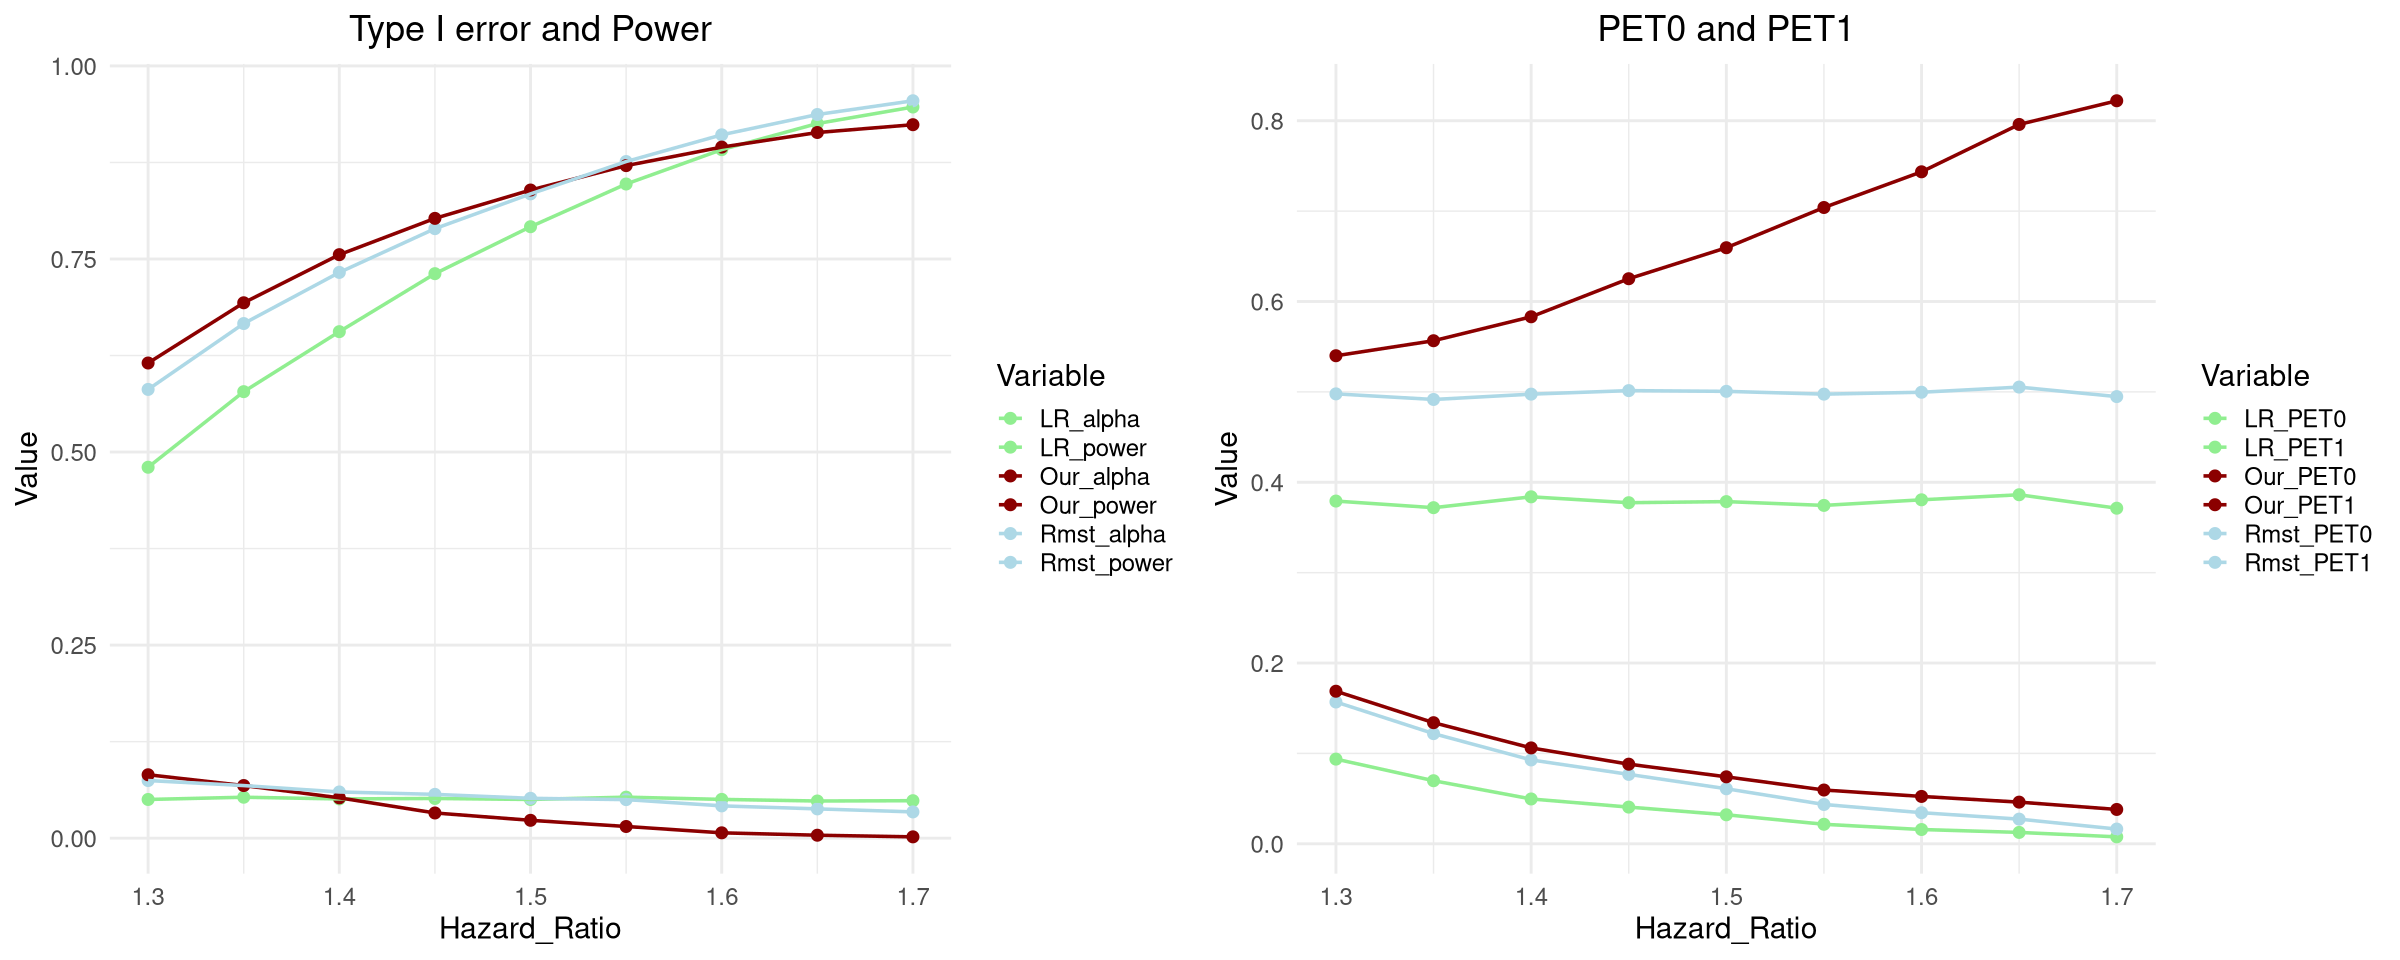

In [12]:
save(diff_HR, file = '/home/r27user6/RMST_Code/RData/robust_diff_hr.RData')
#self-define function for drawing plots
compare_line_plot(data = diff_HR, var_name = 'Hazard_Ratio')

----
# Test for different Interim Period

### Under different interim period ( interim sample size n )
### The changes of power, PET0 and PET1 when overall sample size N is fixed
###  ($\lambda,\gamma$)<span style="color:yellow"> is not fixed. Grid search for each n

In [11]:
sim_size <- 10000
r <- 60
acc_time <- 174 / r
cen_time <- 1
lambda_H0 <- 0.9 * 1.5
lambda_H1 <- 0.9
n <- ceiling(174 / 2)  #per arm
alpha <- 0.05
# different int
base_inter <- 112 / r
int_seq <- seq(from = 0.5, to = 1.5, by = 0.1)
interim_list <- base_inter * int_seq

data_C <- expo_gen_2stages(N = n * sim_size, acc_time = acc_time, lambda = lambda_H0, dist = 'exp', 
                           cen_time = cen_time,arm = 0, interim = interim_list)    
data_E_H0 <- expo_gen_2stages(N = n * sim_size, acc_time = acc_time, lambda = lambda_H0, dist = 'exp', 
                                cen_time = cen_time,arm = 1, interim = interim_list)
data_E_H1 <- expo_gen_2stages(N = n * sim_size, acc_time = acc_time, lambda = lambda_H1, dist = 'exp', 
                                cen_time = cen_time,arm = 1, interim = interim_list) 

diff_interim <- foreach(i = 1:length(interim_list), .combine = 'rbind') %dopar%
{   
    interim <- interim_list[i]
    rmst_int_h0 <- RMST_sim_cal(n = n, data_E = data_E_H0[ , c(2,3,1),i], data_C = data_C[ , c(2,3,1),i],
                            tau = interim,sim_size = sim_size)
    rmst_fin_h0 <- RMST_sim_cal(n = n, data_E = data_E_H0[ , c(4,5,1),i], data_C = data_C[ , c(4,5,1),i],
                            tau = acc_time + cen_time, sim_size = sim_size)                        
    rmst_int_h1 <- RMST_sim_cal(n = n, data_E = data_E_H1[ , c(2,3,1),i], data_C = data_C[ , c(2,3,1),i],
                            tau = interim,sim_size = sim_size)
    rmst_fin_h1 <- RMST_sim_cal(n = n, data_E = data_E_H1[ , c(4,5,1),i], data_C = data_C[ , c(4,5,1),i],
                            tau = acc_time + cen_time, sim_size = sim_size)

    mu_cov_h0 <- mu_cov_mc(rmst_int = rmst_int_h0, rmst_fin = rmst_fin_h0, sim_size = sim_size)
    mu_cov_h1 <- mu_cov_mc(rmst_int = rmst_int_h1, rmst_fin = rmst_fin_h1, sim_size = sim_size)

    best_res <- adp_grid_src(rmst_int_h0 = rmst_int_h0, rmst_fin_h0 = rmst_fin_h0, rmst_int_h1 = rmst_int_h1, 
                rmst_fin_h1 = rmst_fin_h1, mu_cov_h0 = mu_cov_h0, mu_cov_h1 = mu_cov_h1, 
                int_n = interim * r, fin_n = 2 * n, alpha = alpha, sim_size = sim_size) 
    best_res$EN_h0 <- as.numeric(best_res$PET0) * interim * r + 
                    (1 - as.numeric(best_res$PET0)) * n * 2
    best_res$EN_h1 <- as.numeric(best_res$PET1) * interim * r + 
                    (1 - as.numeric(best_res$PET1)) * n * 2              
    
    return(best_res) 
}


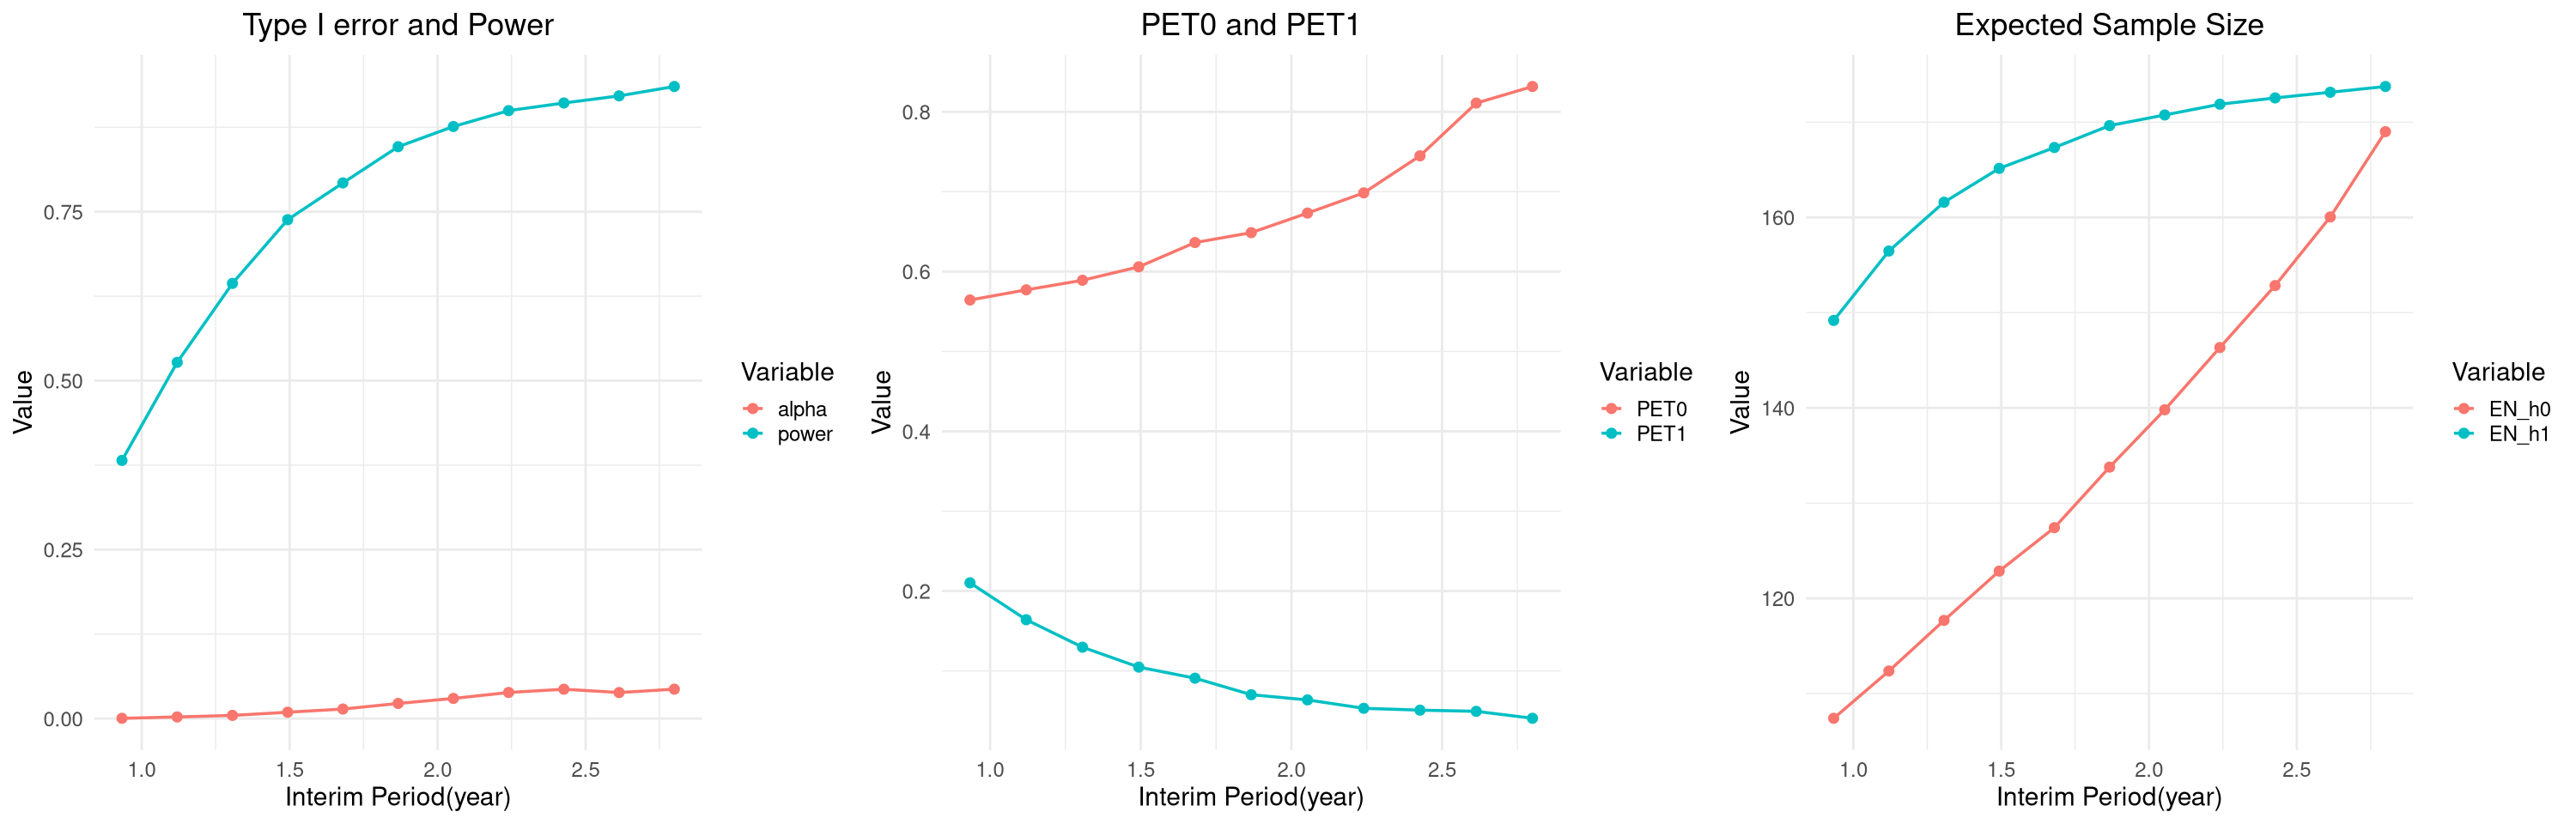

In [12]:
diff_interim$"interim" <- interim_list

options(repr.plot.width = 25, repr.plot.height = 8)
a_power_df <- diff_interim[, c('alpha', 'power', 'interim')]
a_power_long <- a_power_df %>%
  pivot_longer(cols = -interim, names_to = "variable", values_to = "value")
plot1 <- ggplot(a_power_long, aes(x = interim, y = value, color = variable)) +
  geom_point(size = 3) +
  geom_line(linewidth = 1) +
  labs(x = "Interim Period(year)", y = "Value", color = "Variable",
      title = 'Type I error and Power') +
  theme_minimal(base_size = 18) + 
  theme(plot.title = element_text(hjust = 0.5))

pet_df <- diff_interim[, c('PET0', 'PET1', 'interim')]
pet_long <- pet_df %>%
  pivot_longer(cols = -interim, names_to = "variable", values_to = "value")
plot2 <- ggplot(pet_long, aes(x = interim, y = value, color = variable)) +
  geom_point(size = 3) +
  geom_line(linewidth = 1) +
  labs(x = "Interim Period(year)", y = "Value", color = "Variable",
      title = 'PET0 and PET1') +
  theme_minimal(base_size = 18) + 
  theme(plot.title = element_text(hjust = 0.5))

en_df <- diff_interim[, c('EN_h0', 'EN_h1', 'interim')]
en_long <- en_df %>%
  pivot_longer(cols = -interim, names_to = "variable", values_to = "value")
plot3 <- ggplot(en_long, aes(x = interim, y = value, color = variable)) +
  geom_point(size = 3) +
  geom_line(linewidth = 1) +
  labs(x = "Interim Period(year)", y = "Value", color = "Variable",
      title = 'Expected Sample Size') +
  theme_minimal(base_size = 18) + 
  theme(plot.title = element_text(hjust = 0.5))
plot_grid(plot1, plot2, plot3, ncol = 3)

### <span style="color:yellow">  Why the Type I error is so small when n is small ?
Calculate 4 threshold probablity based on the critical value

In [39]:
diff_interim

m1,t1,m2,t2,lambda,gamma,PET0,PET1,alpha,power,interim
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
0.0004173374,0.4531235,0.32813291,0.9441738,0.99,0.77,0.5633,0.2027,0.0005,0.3972,0.9333333
0.0007633792,0.5107803,0.27892538,0.9172830,0.99,0.50,0.5846,0.1619,0.0016,0.5355,1.1200000
0.0010162125,0.5578122,0.23923450,0.8958334,0.99,0.34,0.5986,0.1342,0.0043,0.6459,1.3066667
0.0026311100,0.5956342,0.20621641,0.8778610,0.99,0.24,0.6300,0.1129,0.0093,0.7273,1.4933333
0.0028608378,0.6252628,0.17599613,0.8616582,0.99,0.17,0.6437,0.0898,0.0156,0.7935,1.6800000
0.0003805326,0.6477352,0.14781355,0.8467004,0.99,0.12,0.6570,0.0740,0.0270,0.8426,1.8666667
0.0020625770,0.6684235,0.12596716,0.8348689,0.99,0.09,0.6886,0.0626,0.0360,0.8784,2.0533333
0.0049251149,0.6854022,0.10778138,0.8246940,0.99,0.07,0.7179,0.0524,0.0434,0.9020,2.2400000
0.0137344122,0.7015999,0.09717833,0.8180001,0.99,0.06,0.7526,0.0511,0.0484,0.9134,2.4266667


In [44]:
why_a_small <- diff_interim[ ,c('m1', 't1', 'm2', 't2', 'lambda', 'gamma')]
N <- 174

p2_change <- foreach(i = 1:length(interim_list), .combine = 'rbind') %dopar%
{  
    interim <- interim_list[i]
    rmst_int_h0 <- RMST_sim_cal(n = n, data_E = data_E_H0[ , c(2,3,1),i], data_C = data_C[ , c(2,3,1),i],
                            tau = interim,sim_size = sim_size)
    rmst_fin_h0 <- RMST_sim_cal(n = n, data_E = data_E_H0[ , c(4,5,1),i], data_C = data_C[ , c(4,5,1),i],
                            tau = acc_time + cen_time, sim_size = sim_size)                        
    rmst_int_h1 <- RMST_sim_cal(n = n, data_E = data_E_H1[ , c(2,3,1),i], data_C = data_C[ , c(2,3,1),i],
                            tau = interim,sim_size = sim_size)
    rmst_fin_h1 <- RMST_sim_cal(n = n, data_E = data_E_H1[ , c(4,5,1),i], data_C = data_C[ , c(4,5,1),i],
                            tau = acc_time + cen_time, sim_size = sim_size)
    mu_e_int <- mean(rmst_int_h1[2, ])
    mu_c_int <- mean(rmst_int_h1[1, ])
    sd_e_int <- sd(rmst_int_h1[2, ])
    sd_c_int <- sd(rmst_int_h1[2, ])
    
    p1 <- exp(- why_a_small[i, 'gamma'] * (interim_list[i] * r / N))
    p2 <- why_a_small[i, 'lambda'] * p1

    return(c(mu_e_int, mu_c_int, sd_e_int, sd_c_int, p1, p2)) 
}

In [45]:
p2_change <- data.frame(p2_change)
colnames(p2_change) <- c('mu_E1', 'mu_C1', 'sd_E1', 'sd_C1', 'p1', 'p2')
p2_change

,mu_E1,mu_C1,sd_E1,sd_C1,p1,p2
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
result.1,0.5839440,0.4991391,0.07812012,0.07812012,0.7805035,0.7726984
result.2,0.6581374,0.5481452,0.08467276,0.08467276,0.8243967,0.8161527
result.3,0.7189213,0.5861126,0.08977635,0.08977635,0.8579621,0.8493824
result.4,0.7665886,0.6133996,0.09294974,0.09294974,0.8837455,0.8749080
result.5,0.8050528,0.6334657,0.09564698,0.09564698,0.9062113,0.8971492
result.6,0.8341484,0.6481862,0.09686932,0.09686932,0.9256664,0.9164097
result.7,0.8577008,0.6595931,0.09672826,0.09672826,0.9382638,0.9288812
result.8,0.8764747,0.6677321,0.09646988,0.09646988,0.9473668,0.9378931
result.9,0.8916394,0.6733397,0.09566692,0.09566692,0.9510326,0.9415223


-------